# **Disha Papneja**
##Submission by Disha P

# **Importing Files**

3810 Samples
9 Surfaces
10 Features/Predictors
128 Time Series Steps Per Sample


X_[train/test].csv - the input data, covering 10 sensor channels and 128 measurements per time series plus three ID columns:

* **row_id:** The ID for this row.

* **series_id:**
* **measurement_number: ** ID number for the measurement series. Foreign key to y_train/sample_submission.

* **series_id:**
* **measurement_number: **Measurement number within the series.

Loading Packages in here.

The orientation channels encode the current angles how the robot is oriented as a quaternion . Angular velocity describes the angle and speed of motion, and linear acceleration components describe how the speed is changing at different times. The 10 sensor channels are:


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import sklearn as sk
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
X_data = pd.read_csv("../input/career-con-2019/X_train.csv")
sample_submission = pd.read_csv("../input/career-con-2019/sample_submission.csv")
X_test = pd.read_csv('../input/career-con-2019/X_test.csv')
#Y_test = pd.read_csv('../input/career-con-2019/Y_test.csv')
Y_data = pd.read_csv("../input/career-con-2019/y_train.csv")


X_data.head()
# Any results you write to the current directory are saved as output.

/kaggle/input/career-con-2019/sample_submission.csv
/kaggle/input/career-con-2019/y_train.csv
/kaggle/input/career-con-2019/X_test.csv
/kaggle/input/career-con-2019/X_train.csv


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


# **Data Exploration**

Data exploration is the first step in data analysis, to explore a large data set in an unstructured way to uncover trends, characteristics, and points of interest. Not all the information that a data holds is depicted here, but a broader picture of important trends comes out.

Data exploration can use a combination of manual methods and automated tools such as data visualizations, charts, and initial reports.

When the data set is massive, data exploration can help to break it to a manageable size and focu efforts to optimize analysis.

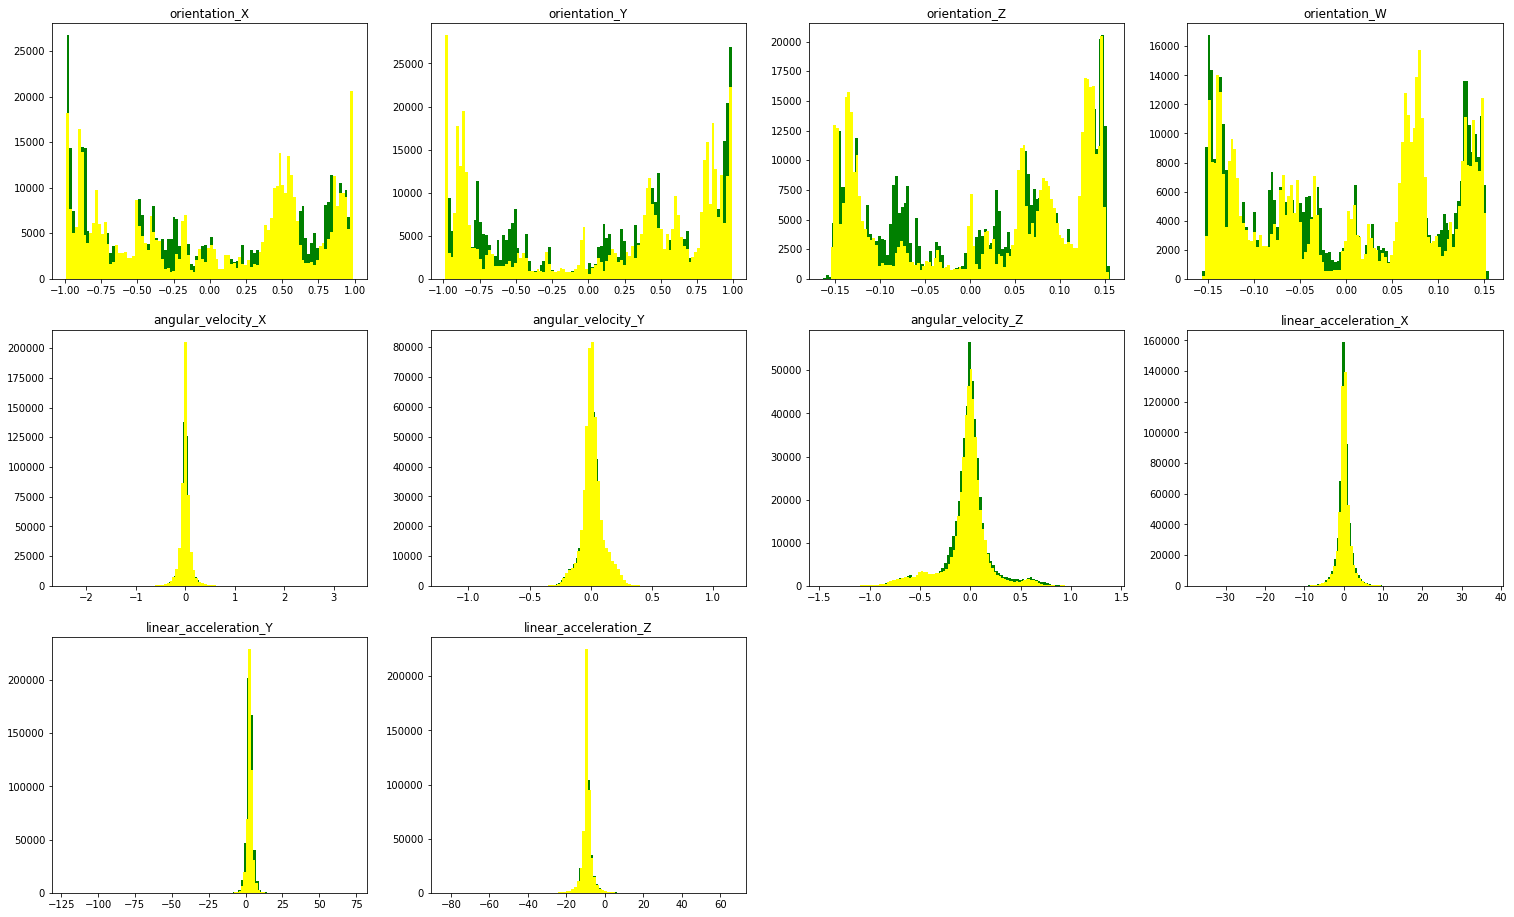

In [2]:
#data exploration
import matplotlib.pyplot as plt
X_data.shape, Y_data.shape
plt.figure(figsize=(26, 16))
for i, col in enumerate(X_data.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.hist(X_data[col], color='green', bins=100)
    plt.hist(X_test[col], color='yellow', bins=100)
    plt.title(col)
# countplot(y_data = 'surface', data = target)
# plt.show()

# **Feature Engineering**

Feature engineering is adding new input features( or data) to existing dataset by using domain knowledge.
According to Wikipedia: A feature is an attribute or property shared by all of the independent units on which analysis or prediction is to be done. Any attribute could be a feature, as long as it is useful to the model. The purpose of a feature, other than being an attribute, would be much easier to understand in the context of a problem. A feature is a characteristic that might help when solving the problem.[

Here are the following important points of our dataset  which have been used as a part of feature engineering:

Features/ Predictors:
* Linear Acceleration
* Angular Velocity
* Orientation

4D to 3D conversion: Usually we have X, Y, Z - Euler Angles. But Euler Angles are limited by a phenomenon called "gimbal lock," which prevents them from measuring orientation when the pitch angle approaches +/- 90 degrees. 4D data or quaternions provide an alternative measurement technique that does not suffer from gimbal lock. Quaternions are less intuitive than Euler Angles and the math can be a little more complicated.

Class Imbalance:
* Do Nothing
* Undersampling / Oversampling
* Weighting
* SMOTE (Synthetic Minority Over-sampling Technique)-SMOTE is helpful for skewed classification problems
* Conv1D are great for modelling sequence data
* Data Leakage: Always consider how your model is learning


Feature generation

We have 128 measurements in each series, so it makes sense to create aggregate features. I create several groups of them:

Usual aggregations: mean, std, min and max, absolute min and max. Max to min rate;
Mean change rate in absolute and relative values - it shows how fast values change;
Quantiles - showing extreme values;
Trend features - to show whether values decrease or increase;
Rolling features - to show mean/std values with windows;





In [3]:
#Feature Engineering
df = pd.DataFrame()


cols = ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W', 'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']

#This section is heavily borrowed from: https://www.kaggle.com/vanshjatana/help-humanity-by-helping-robots Kernel and https://www.kaggle.com/gpreda/robots-need-help#Features-engineering


#4D to 3D conversion

def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z


def perform_euler_factors_calculation(df):
    df['ttl_anglr_vel'] = (df['angular_velocity_X']**2 + df['angular_velocity_Y']**2 + df['angular_velocity_Z']**2)** 0.5
    df['ttl_linr_acc'] = (df['linear_acceleration_X']**2 + df['linear_acceleration_Y']**2 + df['linear_acceleration_Z']**2)**0.5
    df['ttl_xyz'] = (df['orientation_X']**2 + df['orientation_Y']**2 + df['orientation_Z']**2)**0.5
    df['acc_vs_vel'] = df['ttl_linr_acc'] / df['ttl_anglr_vel']
    x, y, z, w = df['orientation_X'].tolist(), df['orientation_Y'].tolist(), df['orientation_Z'].tolist(), df['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
            xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
            nx.append(xx)
            ny.append(yy)
            nz.append(zz)
    
    df['euler_x'] = nx
    df['euler_y'] = ny
    df['euler_z'] = nz
    
    df['total_angle'] = np.sqrt(np.square(df['euler_x']) + np.square(df['euler_y']) + np.square(df['euler_z']))
    df['angle_vs_acc'] = df['total_angle'] / df['ttl_linr_acc']
    df['angle_vs_vel'] = df['total_angle'] / df['ttl_anglr_vel']
    return df


#applying more aggregation functions


def perform_feature_engineering(df):
    df2=pd.DataFrame()
    for col in cols:
        df2[col + '_mean'] = df.groupby('series_id')[col].mean()
        df2[col + '_std'] = df.groupby('series_id')[col].std()
        df2[col + '_min'] = df.groupby(['series_id'])[col].min()
        df2[col + '_max'] = df.groupby(['series_id'])[col].max()
        df2[col + '_std'] = df.groupby(['series_id'])[col].std()
        df2[col + '_med'] = df.groupby(['series_id'])[col].median()
        df2[col + '_skew'] = df.groupby(['series_id'])[col].skew()
        df2[col + '_range'] = df2[col + '_max'] - df2[col + '_min']
        df2[col + '_max_to_min'] = df2[col + '_max'] / df2[col + '_min']
        #df2[col + '_mean_abs_change'] = df.groupby('series_id')[col].apply(mean_abs_change)
        #df2[col + '_mean_change_of_abs_change'] = df.groupby('series_id')[col].apply(mean_change_of_abs_change)
        df2[col + '_abs_max'] = df.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
        df2[col + '_abs_min'] = df.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))
        df2[col + '_abs_mean'] = df.groupby('series_id')[col].apply(lambda x: np.mean(np.abs(x)))
        df2[col + '_abs_std'] = df.groupby('series_id')[col].apply(lambda x: np.std(np.abs(x)))
        df2[col + '_abs_avg'] = (df2[col + '_abs_min'] + df2[col + '_abs_max'])/2
        df2[col + '_abs_range'] = df2[col + '_abs_max'] - df2[col + '_abs_min']
    return df2
print("Feature Engineering")


Feature Engineering


In [4]:

#X_data=perform_euler_factors_calculation(X_data)
X_data = perform_euler_factors_calculation(X_data)
X_test = perform_euler_factors_calculation(X_test)

X_data.shape, X_test.shape
#X_data.head()
#X_test.head()

((487680, 23), (488448, 23))

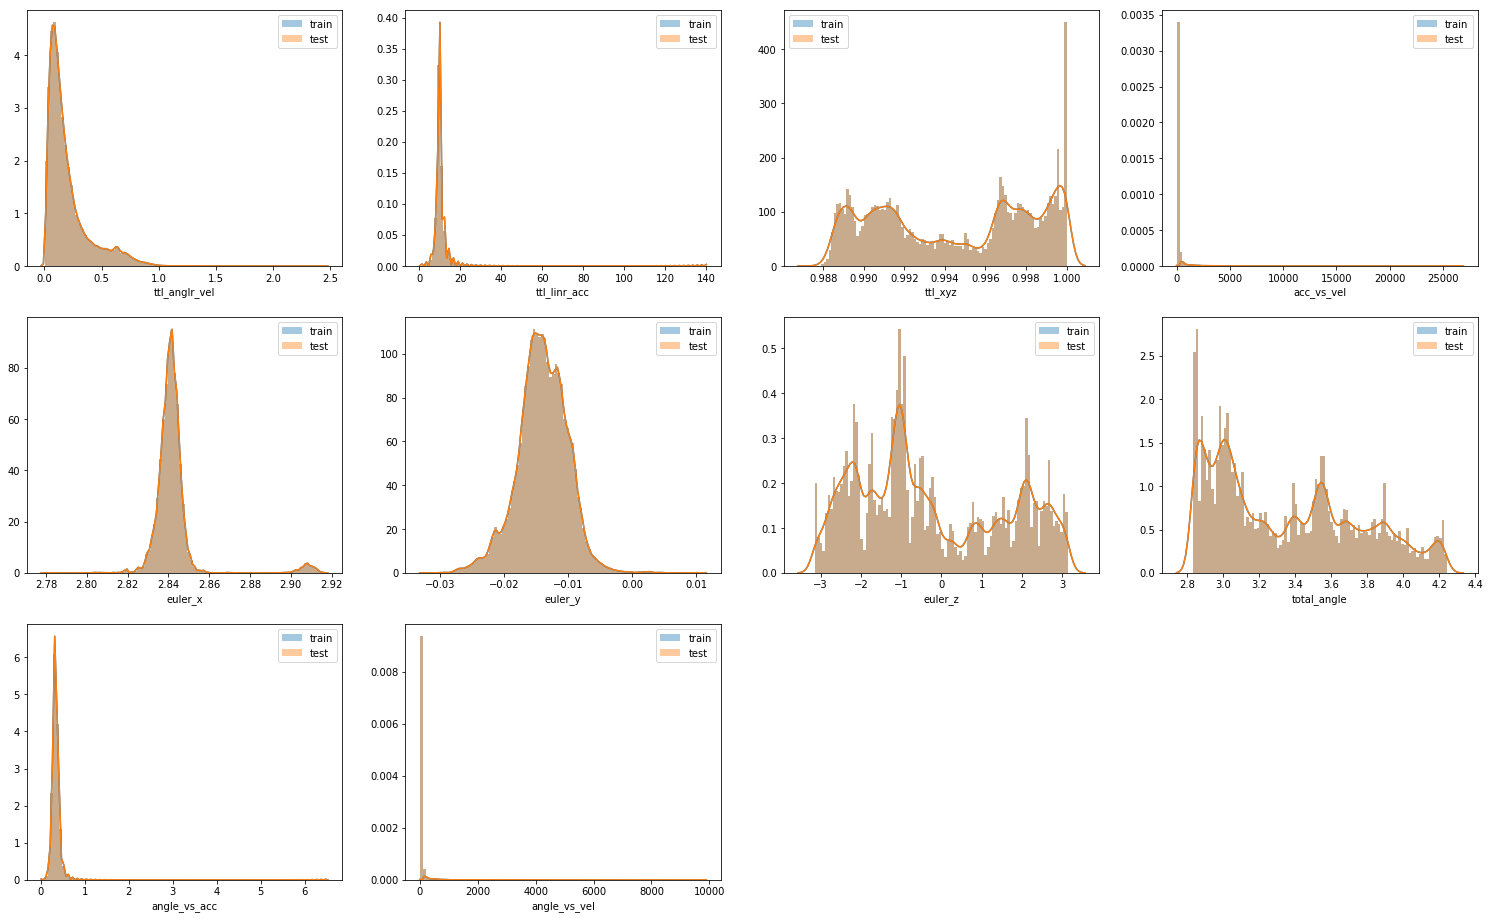

In [5]:
#plotting visual graphs for feature engineering


import seaborn as sns
plt.figure(figsize=(26, 16))
for i, col in enumerate(X_data.columns[13:]):
    ax = plt.subplot(3, 4, i+1)
    sns.distplot(X_data[col], bins=100, label='train')
    sns.distplot(X_data[col], bins=100, label='test')
    ax.legend()  

In [6]:

#performing feature engineering

X_data = perform_feature_engineering(X_data)
X_test = perform_feature_engineering(X_test)
X_data.head()
# plt.figure(figsize=(26, 16))
# for i, col in enumerate(X_data.columns[:]):
#     ax = plt.subplot(4, 5, i + 1)
#     sns.distplot(X_data[col], bins=100, label='train')
#     sns.distplot(X_data[col], bins=100, label='test')
#     ax.legend()  

,orientation_X_mean,orientation_X_std,orientation_X_min,orientation_X_max,orientation_X_med,orientation_X_skew,orientation_X_range,orientation_X_max_to_min,orientation_X_abs_max,orientation_X_abs_min,...,linear_acceleration_Z_med,linear_acceleration_Z_skew,linear_acceleration_Z_range,linear_acceleration_Z_max_to_min,linear_acceleration_Z_abs_max,linear_acceleration_Z_abs_min,linear_acceleration_Z_abs_mean,linear_acceleration_Z_abs_std,linear_acceleration_Z_abs_avg,linear_acceleration_Z_abs_range
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,0.000363,-0.75953,-0.75822,-0.758530,-0.659082,0.00131,0.998275,0.75953,0.75822,...,-9.42995,0.067391,6.2439,0.500967,12.512,6.2681,9.320391,1.090754,9.39005,6.2439
1,-0.958606,0.000151,-0.95896,-0.95837,-0.958595,-0.397289,0.00059,0.999385,0.95896,0.95837,...,-9.41380,-0.126848,14.1831,0.162151,16.928,2.7449,9.388899,2.114756,9.83645,14.1831
2,-0.512057,0.001377,-0.51434,-0.50944,-0.512035,0.151971,0.00490,0.990473,0.51434,0.50944,...,-9.37440,0.085877,6.7548,0.459573,12.499,5.7442,9.395783,1.135804,9.12160,6.7548
3,-0.939169,0.000227,-0.93968,-0.93884,-0.939170,-0.096106,0.00084,0.999106,0.93968,0.93884,...,-9.16170,-0.210103,19.2859,0.028173,19.845,0.5591,9.451164,3.464915,10.20205,19.2859
4,-0.891301,0.002955,-0.89689,-0.88673,-0.890940,-0.226700,0.01016,0.988672,0.89689,0.88673,...,-9.33280,0.106132,3.5260,0.678724,10.975,7.4490,9.349988,0.809405,9.21200,3.5260


# **Filling in Missing Values- Data Cleaning**



In [7]:
#filling missing values

X_data.fillna(0,inplace=True)
X_test.fillna(0,inplace=True)
X_data.replace(-np.inf,0,inplace=True)
X_data.replace(np.inf,0,inplace=True)
X_test.replace(-np.inf,0,inplace=True)
X_test.replace(np.inf,0,inplace=True)

# ** Encoding Labels **

According to GeeksforGeeks:

In machine learning, we usually deal with datasets which contains multiple labels in one or more than one columns. 
These labels can be in the form of words or numbers. To make the data understandable or in human readable form, 
The training data is often labeled in words.
Label Encoding refers to converting the labels into numeric form so as to convert it into the machine-readable form. 
Machine learning algorithms can then decide in a better way on how those labels must be operated. 
It is an important pre-processing step for the structured dataset in supervised learning.


In [8]:
#encoding labels
labelEncoder = LabelEncoder()
Y_data['surfaceLabel'] = Y_data['surface']
Y_data['surfaceLabel'] = labelEncoder.fit_transform(Y_data['surfaceLabel'])
Y_data.head(10)

,series_id,group_id,surface,surfaceLabel
0,0,13,fine_concrete,2
1,1,31,concrete,1
2,2,20,concrete,1
3,3,31,concrete,1
4,4,22,soft_tiles,6
5,5,1,tiled,7
6,6,34,soft_pvc,5
7,7,31,concrete,1
8,8,33,hard_tiles_large_space,4
9,9,11,tiled,7


# ** Splitting Training and Testing Data **

In [9]:
#splitting training and testing data
#y_train = pd.read_csv('/kaggle/input/career-con-2019/y_train.csv')
# split X_train
samples = 20
start_x = X_data.shape[0] - samples
X_data_new, X_test_new = X_data.iloc[:start_x], X_data.iloc[start_x:]
# split y_train
start_Y = Y_data.shape[0] - samples
Y_data_new, Y_test_new = Y_data.iloc[:start_Y], Y_data.iloc[start_Y:]

Y_data_new = Y_data_new['surfaceLabel']
Y_test_new = Y_test_new['surfaceLabel']
print('Data Split')

Data Split


# **Review Training and Testing Data **

In [10]:
#review training and testing data
 

print('TRAINING FEATURES')
print('SHAPE: ',X_data_new.shape)
print(X_data_new.head())

print('\nTRAINING LABELS')
print('SHAPE: ',Y_data_new.shape)
print(Y_data_new.head())

print('\nTESTING FEATURES')
print('SHAPE: ',X_test_new.shape)
print(X_test_new.head())

print('\nTESTING LABELS')
print('SHAPE: ',Y_test_new.shape)
print(Y_test_new.head())

TRAINING FEATURES
SHAPE:  (3790, 140)
           orientation_X_mean  orientation_X_std  orientation_X_min  \
series_id                                                             
0                   -0.758666           0.000363           -0.75953   
1                   -0.958606           0.000151           -0.95896   
2                   -0.512057           0.001377           -0.51434   
3                   -0.939169           0.000227           -0.93968   
4                   -0.891301           0.002955           -0.89689   

           orientation_X_max  orientation_X_med  orientation_X_skew  \
series_id                                                             
0                   -0.75822          -0.758530           -0.659082   
1                   -0.95837          -0.958595           -0.397289   
2                   -0.50944          -0.512035            0.151971   
3                   -0.93884          -0.939170           -0.096106   
4                   -0.88673          

1. # **Training the Model **



 The process of training an ML model involves providing an ML algorithm (that is, the learning algorithm) with training data to learn from. The term ML model refers to the model artifact that is created by the training process.

The training data must contain the correct answer, which is known as a target or target attribute. The learning algorithm finds patterns in the training data that map the input data attributes to the target (the answer that you want to predict), and it outputs an ML model that captures these patterns.

You can use the ML model to get predictions on new data for which you do not know the target. For example, let's say that you want to train an ML model to predict if an email is spam or not spam. You would provide Amazon ML with training data that contains emails for which you know the target (that is, a label that tells whether an email is spam or not spam). Amazon ML would train an ML model by using this data, resulting in a model that attempts to predict whether new email will be spam or not spam.

Source: https://docs.aws.amazon.com/machine-learning/latest/dg/training-ml-models.html


I have tried Random Forest and CNN models, since with CNN I wasn't able to get good accuracy I've included only Random Forest Classification model.
I'll breifly describe my attempts with 1D convulation Layer. An extracted patch was taken from a window size 5 and weights and biases were given to output.
So the steps were:
Conv 1-D-> Batch Normalization -> Pooling
These steps were taken from different windows. Meta features were taken out and concatenated to give the output.


For Validation Strategy I have used Stratified KFold. In stratified k-fold cross-validation, the folds are selected so that the mean response value is approximately equal in all the folds. In the case of a dichotomous classification, this means that each fold contains roughly the same proportions of the two types of class labels.

As this is a multi class classification problem. My first intuition was Random Forest Classifier algorithm.


-------------------- 0 --------------------
score  0.8707124010554089


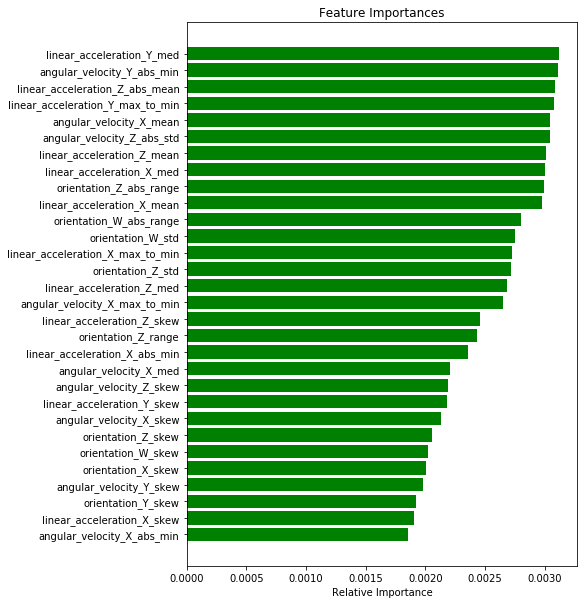

-------------------- 1 --------------------
score  0.866754617414248


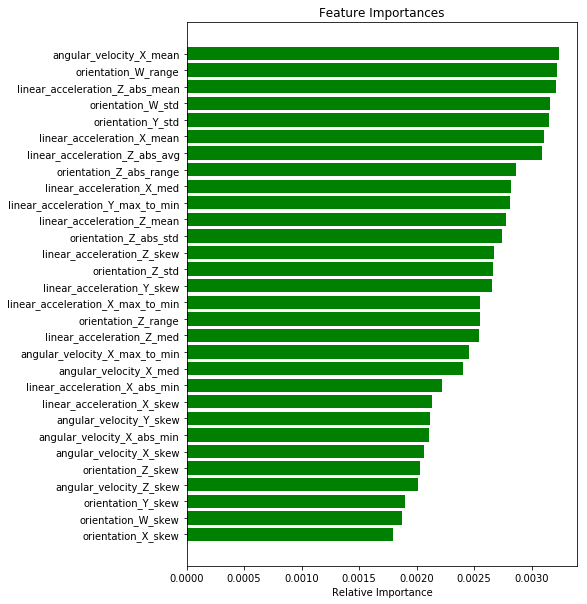

-------------------- 2 --------------------
score  0.8707124010554089


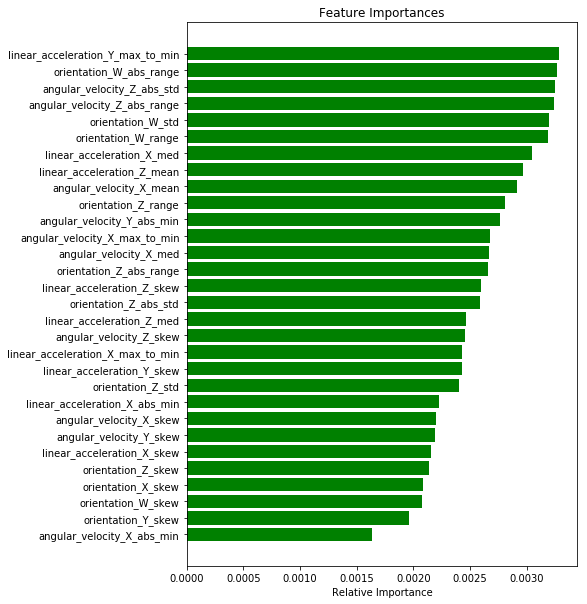

-------------------- 3 --------------------
score  0.8469656992084432


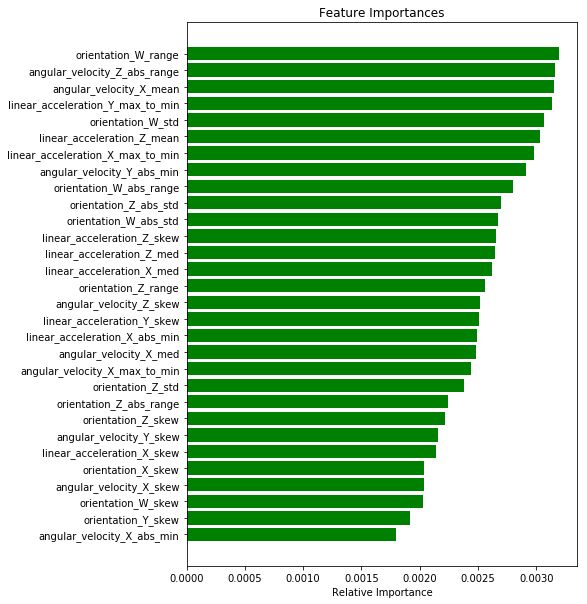

-------------------- 4 --------------------
score  0.8839050131926122


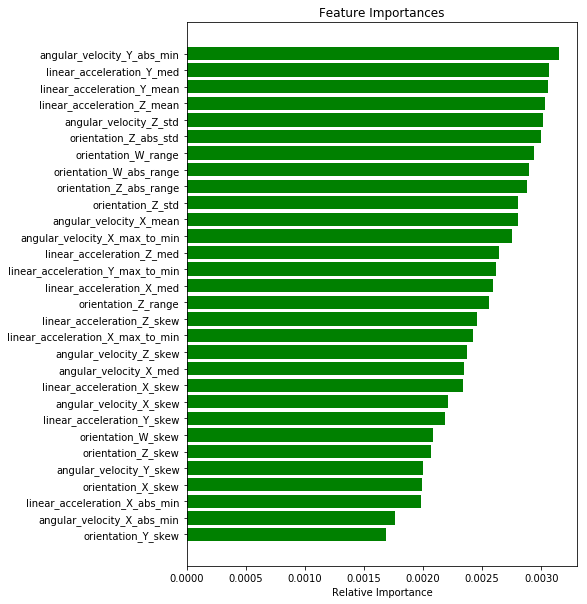

Avg Accuracy 0.8678100263852242


In [11]:

#Validation Strategy: Stratified KFold

#This part is heavily borrowed from https://www.kaggle.com/prashantkikani/help-humanity-by-helping-robots/data

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=546789)
sub_preds_rf = np.zeros((X_test_new.shape[0], 9))
oof_preds_rf = np.zeros((X_data_new.shape[0]))
score = 0
for i, (train_index, test_index) in enumerate(folds.split(X_data_new, Y_data_new)):
    print('-'*20, i, '-'*20)
    
    clf =  RandomForestClassifier(n_estimators = 200, n_jobs = -1)
    clf.fit(X_data.iloc[train_index], Y_data_new[train_index])
    oof_preds_rf[test_index] = clf.predict(X_data_new.iloc[test_index])
    sub_preds_rf += clf.predict_proba(X_test_new) / folds.n_splits
    score += clf.score(X_data_new.iloc[test_index], Y_data_new[test_index])
    print('score ', clf.score(X_data_new.iloc[test_index], Y_data_new[test_index]))
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    features = X_data_new.columns

    hm = 30
    plt.figure(figsize=(7, 10))
    plt.title('Feature Importances')
    plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='g', align='center')
    plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

print('Avg Accuracy', score / folds.n_splits)

In [12]:
#training the model

model = RandomForestClassifier(n_estimators = 200, max_depth = 15, n_jobs = -1)
model.fit(X_data_new,Y_data_new)
print('Model Trained')

Model Trained


# **Training Accuracy **

Using Random Forest without Stratified KFold


In [13]:
#training accuracy
from sklearn import metrics
trainingAccuracy = metrics.accuracy_score(np.array(Y_data_new), model.predict(X_data_new))
print(trainingAccuracy)

#testing accuracy
from sklearn import metrics

testingAccuracy = metrics.accuracy_score(np.array(Y_test_new), model.predict(X_test_new))
print(testingAccuracy)

0.9976253298153034
0.9


Text(0.5, 24.0, 'Predicted label')

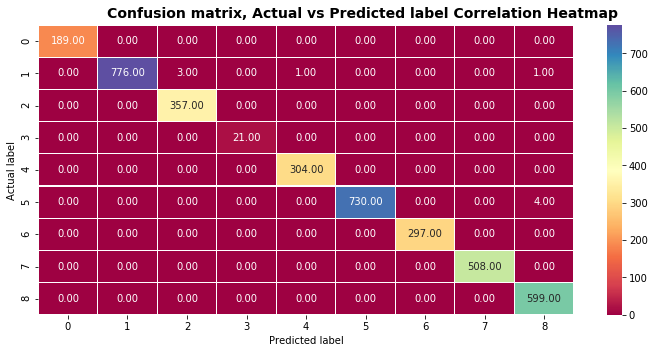

In [14]:
#confusion Matrix
from sklearn.metrics import confusion_matrix 
measured= model.predict(X_data_new)
#measured= np.zeros((Y_data.shape[0]))

fig, ax = plt.subplots(1,1,figsize=(12,5))
sns.heatmap(pd.DataFrame(confusion_matrix(measured,Y_data_new)),
            ax = ax,
            cmap = 'Spectral',
            annot = True,
            fmt = '.2f',
            linewidths = 0.05)
fig.subplots_adjust(top=0.93)
fig.suptitle('Confusion matrix, Actual vs Predicted label Correlation Heatmap', 
              fontsize=14, 
              fontweight='bold')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')